In [1]:
import pathlib

import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm

import arviz as az
from aesara_theano_fallback import tensor as tt
import pymc3 as pm
import pymc3_ext as pmx

from helpers import download_file

In [2]:
local_cache_path = pathlib.Path('../data/').resolve().absolute()
local_cache_path.mkdir(exist_ok=True)

In [3]:
allstar_path = local_cache_path / 'allStarLite-dr17-synspec_rev1.fits'
if not allstar_path.exists():
    url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits"
    download_file(
        url, 
        local_path=allstar_path.parent, 
        local_filename=allstar_path.parts[-1]
    )
allstar = at.QTable.read(allstar_path)

In [4]:
metadata_path = local_cache_path / 'metadata.fits'
if not metadata_path.exists():
    url = "https://users.flatironinstitute.org/~apricewhelan/data/apogee-dr17-binaries/metadata.fits"
    download_file(
        url, 
        local_path=metadata_path.parent, 
        local_filename=metadata_path.parts[-1]
    )
metadata = at.QTable.read(metadata_path)
metadata = at.unique(at.join(allstar, metadata, keys='APOGEE_ID'), 
                     keys='APOGEE_ID')

In [5]:
llr_const = metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood']
binaries_mask = (llr_const > 4)
binaries_mask.sum()

75813

In [40]:
def get_fit_data(mask, logg_bins=None):
    if logg_bins is None:
        logg_bins = np.arange(-0.25, 5.5, 0.05)
    
    logg_binc = 0.5 * (logg_bins[:-1] + logg_bins[1:])
    
    H_bin, _ = np.histogram(metadata['LOGG'][binaries_mask & mask], 
                            bins=logg_bins)
    H_all, _ = np.histogram(metadata['LOGG'][mask], 
                            bins=logg_bins)
    
    # TODO: can use math to do this instead, lazy 
    ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) / 
             np.random.poisson(H_all, size=(1_000, len(H_all))))

    data_x = logg_binc
    data_y = np.mean(ratio, axis=0)
    data_yerr = np.std(ratio, axis=0)

    sort_idx = np.argsort(data_x)
    data_x = data_x[sort_idx]
    data_y = data_y[sort_idx]
    data_yerr = data_yerr[sort_idx]

    good_idx = np.isfinite(data_y) & (data_y != 0) & (data_yerr != 0)
    data_x = data_x[good_idx]
    data_y = data_y[good_idx]
    data_yerr = data_yerr[good_idx]
    
    return data_x, data_y, data_yerr

In [41]:
mh_mask = metadata['M_H'] > -1.
data_x, data_y, data_yerr = get_fit_data(mh_mask)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'obs. binary fraction')

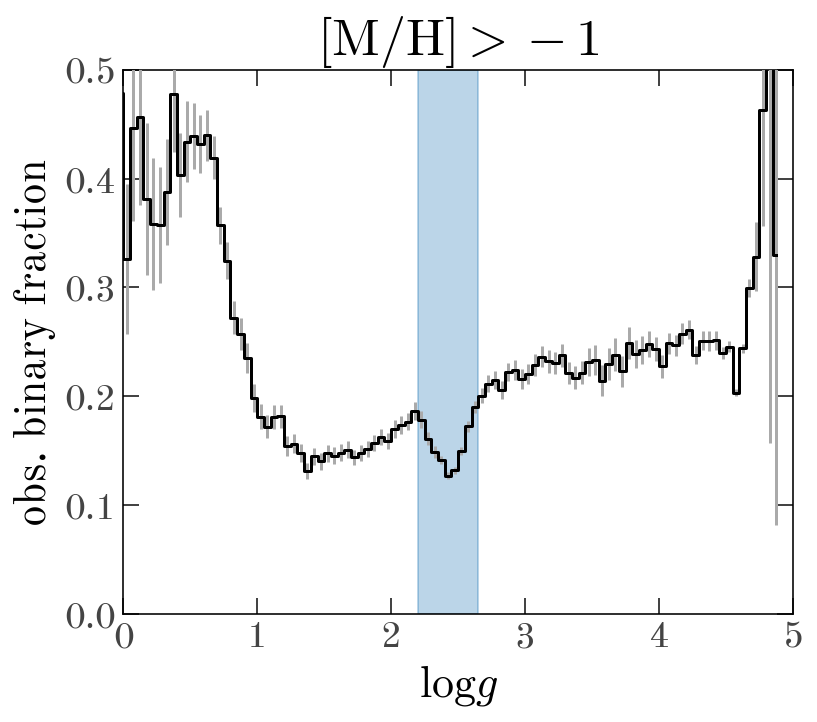

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(data_x,
        data_y,
        marker='', drawstyle='steps-mid', zorder=10)

ax.errorbar(data_x,
            data_y,
            data_yerr,
            ecolor='#aaaaaa', ls='none', marker='', zorder=5)

ax.set_title(r'$[{\rm M}/{\rm H}] > -1$')
ax.set_xlim(0., 4.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel(r'$\log g$')

ax.set_xticks(np.arange(0, 5+1, 1))

ax.axvspan(2.2, 2.65, color='tab:blue', alpha=0.3)

ax.set_ylabel('obs. binary fraction')

In [43]:
fit_idx = (
    (data_x > 1.4) &
    np.logical_not((data_x > 2.2) & (data_x < 2.65)) &
    (data_x < 4.5)
)
fit_x = data_x[fit_idx]
fit_y = data_y[fit_idx]
fit_yerr = data_yerr[fit_idx]

In [44]:
def get_samples(x, y, yerr):
    
    init_const = np.nanmedian(y[(x > 3) & (x < 4.5)])
    init_slope = (init_const - np.nanmedian(y[(x > 1.2) & (x < 2)])) / (3.75 - 1.6)
    
    with pm.Model() as model:    
        break_x = pm.Uniform('break_x', 2.5, 4)
        const_y = pm.Uniform('const_y', 0., 1)
        slope = pm.Uniform('slope', 1e-4, 1)

        model_y = tt.where(x < break_x, 
                           slope * (x - break_x) + const_y, 
                           const_y)
        lnlike = pm.Normal('lnlike', mu=model_y, sd=yerr, observed=y)

        res = pmx.optimize(start={
            'break_x': 2.8,
            'const_y': init_const,
            'slope': init_slope
        })

        samples = pmx.sample(start=res, return_inferencedata=True, cores=1)
    
    return samples

In [45]:
samples = get_samples(fit_x, fit_y, fit_yerr)

optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -83.15226289465691 -> 170.0200879337294



{'break_x_interval__': array(0.68078642), 'const_y_interval__': array(-1.13303789), 'slope_interval__': array(-2.91987578), 'break_x': array(3.49587129), 'const_y': array(0.2436009), 'slope': array(0.05127461)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [21]:
def get_model_y(x, res, subN=None, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
        
    if isinstance(res, dict):
        model_y = np.where(x < res['break_x'],
                           res['slope'] * (x - res['break_x']) + res['const_y'],
                           res['const_y'])
        return model_y
    
    elif isinstance(res, az.InferenceData):
        size = res.posterior.draw.size * res.posterior.chain.size
        samples = {k: res.posterior.get(k).values.ravel() 
                   for k in res.posterior.data_vars}
        
        if subN is not None:
            idx = rng.choice(size, size=subN, replace=False)
        else:
            idx = np.arange(size)
        
        if len(idx) > 1000:
            raise NotImplementedError()
            
        all_model_y = []
        for i in idx:
            model_y = get_model_y(x, {k: samples[k][i] for k in samples.keys()})
            all_model_y.append(model_y)
        
        return np.array(all_model_y)

In [22]:
min_idx = np.abs(data_x - 2.4).argmin()
# min_idx = np.where((data_x > 2) & (data_x < 3))[0]
# min_idx = min_idx[np.argmin(data_y[min_idx])]
print(data_x[min_idx])
data_y[min_idx], data_yerr[min_idx]

2.4249999999999994


(0.1269550509233414, 0.003007208029085635)

In [23]:
tmp = get_model_y(data_x[min_idx], samples, subN=512)
pred_min_y = np.mean(tmp)
pred_min_yerr = np.std(tmp)
pred_min_y, pred_min_yerr

(0.189159554241081, 0.0016581569724728824)

Text(0, 0.5, 'obs. binary fraction')

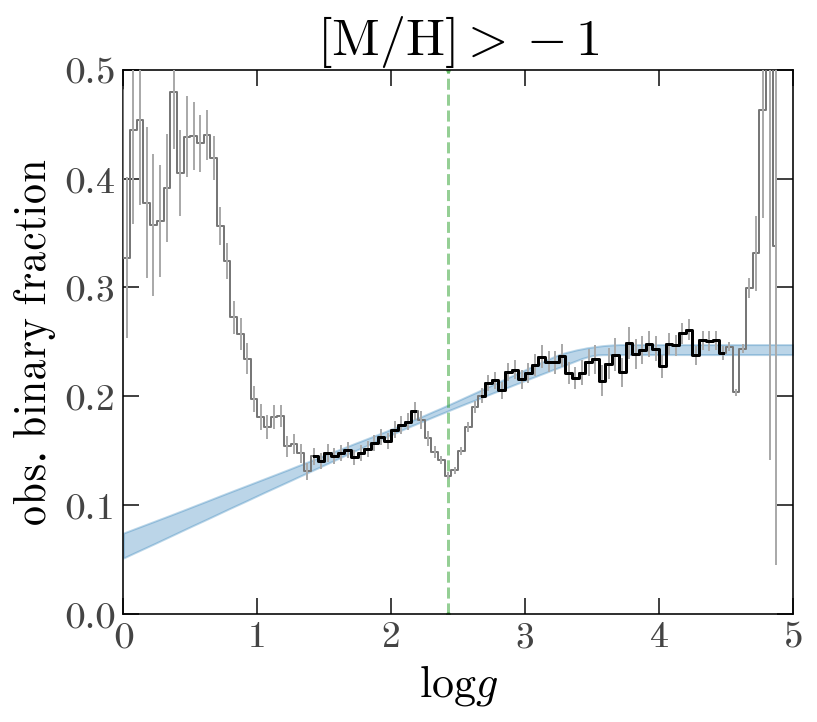

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(data_x,
        data_y,
        marker='', drawstyle='steps-mid', zorder=10,
        color='#777777', linewidth=1)

_idx = np.concatenate(([0], np.where(np.diff(fit_x) > 0.1)[0]+1, [len(fit_x)]))
for i1, i2 in zip(_idx[:-1], _idx[1:]):
    ax.plot(fit_x[i1:i2],
            fit_y[i1:i2],
            marker='', drawstyle='steps-mid', color='k', zorder=100)
    
ax.errorbar(data_x,
            data_y,
            data_yerr,
            ecolor='#aaaaaa', ls='none', marker='', zorder=100, elinewidth=1)

grid_x = np.linspace(0, 5, 128)
pcl1, pcl2 = np.percentile(get_model_y(grid_x, samples, subN=512),
                           q=[5, 95], axis=0)
plt.fill_between(grid_x, pcl1, pcl2, color='tab:blue', alpha=0.3)
# plt.plot(grid_x, get_model_y(grid_x, samples, subN=512).T, 
#          marker='', color='tab:blue', alpha=0.1)

ax.set_title(r'$[{\rm M}/{\rm H}] > -1$')
ax.set_xlim(0., 4.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel(r'$\log g$')

ax.set_xticks(np.arange(0, 5+1, 1))

ax.axvline(data_x[min_idx], color='tab:green', linestyle='--', alpha=0.5)

ax.set_ylabel('obs. binary fraction')

## Fit in bins of metallicity?

In [50]:
mh_bin_centers = np.linspace(-1.8, 0.5, 8)
d_mh = mh_bin_centers[1] - mh_bin_centers[0]

rows = []

for i, mh in enumerate(mh_bin_centers):
    row = {}
    row['mh'] = mh
    row['mh_mask'] = np.abs(metadata['M_H'] - mh) < d_mh
    
    if (binaries_mask & mh_mask).sum() < 10_000:
        row['logg_bins'] = np.arange(-0.25, 5.5, 0.1)
    else:
        row['logg_bins'] = np.arange(-0.25, 5.5, 0.05)
    
    row['data_x'], row['data_y'], row['data_yerr'] = get_fit_data(
        row['mh_mask'], logg_bins=row['logg_bins'])
    fit_idx = (
        (row['data_x'] > 1.4) &
        np.logical_not((row['data_x'] > 2.2) & (row['data_x'] < 2.65)) &
        (row['data_x'] < 4.5)
    )
    row['fit_x'] = row['data_x'][fit_idx]
    row['fit_y'] = row['data_y'][fit_idx]
    row['fit_yerr'] = row['data_yerr'][fit_idx]
    row['mh_samples'] = get_samples(row['fit_x'], row['fit_y'], row['fit_yerr'])
    
    min_idx = np.abs(row['data_x'] - 2.4).argmin()
    tmp = get_model_y(row['data_x'][min_idx], row['mh_samples'], subN=512)
    
    row['data_y_min'] = row['data_y'][min_idx]
    row['data_y_min_err'] = row['data_yerr'][min_idx]
    row['pred_y_min'] = np.mean(tmp)
    row['pred_y_min_err'] = np.std(tmp)
    
    rows.append(row)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -429.21421958473326 -> 17.813684860720286



{'break_x_interval__': array(0.37307093), 'const_y_interval__': array(0.38809814), 'slope_interval__': array(-1.14041068), 'break_x': array(3.38830122), 'const_y': array(0.59582478), 'slope': array(0.24232074)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -363.4243176011231 -> 24.27942917651158



{'break_x_interval__': array(0.35087219), 'const_y_interval__': array(0.11019233), 'slope_interval__': array(-1.30525038), 'break_x': array(3.3802436), 'const_y': array(0.52752024), 'slope': array(0.21336138)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Desired error not necessarily achieved due to precision loss.
logp: -227.4278817818892 -> 48.191449463314925



{'break_x_interval__': array(0.92858893), 'const_y_interval__': array(-0.07302498), 'slope_interval__': array(-1.57707334), 'break_x': array(3.57518338), 'const_y': array(0.48175186), 'slope': array(0.17129325)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -118.09803951056635 -> 108.56761032076751



{'break_x_interval__': array(1.03815809), 'const_y_interval__': array(-0.70564807), 'slope_interval__': array(-2.30471247), 'break_x': array(3.60774168), 'const_y': array(0.33056117), 'slope': array(0.09082435)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -72.65928980661853 -> 149.20840797721254



{'break_x_interval__': array(1.18952253), 'const_y_interval__': array(-1.05734094), 'slope_interval__': array(-2.85021341), 'break_x': array(3.64998349), 'const_y': array(0.25781793), 'slope': array(0.05476482)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -14.933558919936686 -> 161.850915249723



{'break_x_interval__': array(0.78488108), 'const_y_interval__': array(-1.16845779), 'slope_interval__': array(-2.95460014), 'break_x': array(3.53009672), 'const_y': array(0.23713386), 'slope': array(0.04961459)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: 80.84093633825071 -> 151.17195956636886



{'break_x_interval__': array(0.02570407), 'const_y_interval__': array(-1.20982218), 'slope_interval__': array(-2.9197457), 'break_x': array(3.25963849), 'const_y': array(0.22973252), 'slope': array(0.05128093)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
optimizing logp for variables: [slope, const_y, break_x]


message: Desired error not necessarily achieved due to precision loss.
logp: 103.13438905210714 -> 114.28576129222171



{'break_x_interval__': array(-1.73456753), 'const_y_interval__': array(-1.21630901), 'slope_interval__': array(-2.72065257), 'break_x': array(2.72500641), 'const_y': array(0.22858665), 'slope': array(0.06185946)}


Sequential sampling (2 chains in 1 job)
NUTS: [slope, const_y, break_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


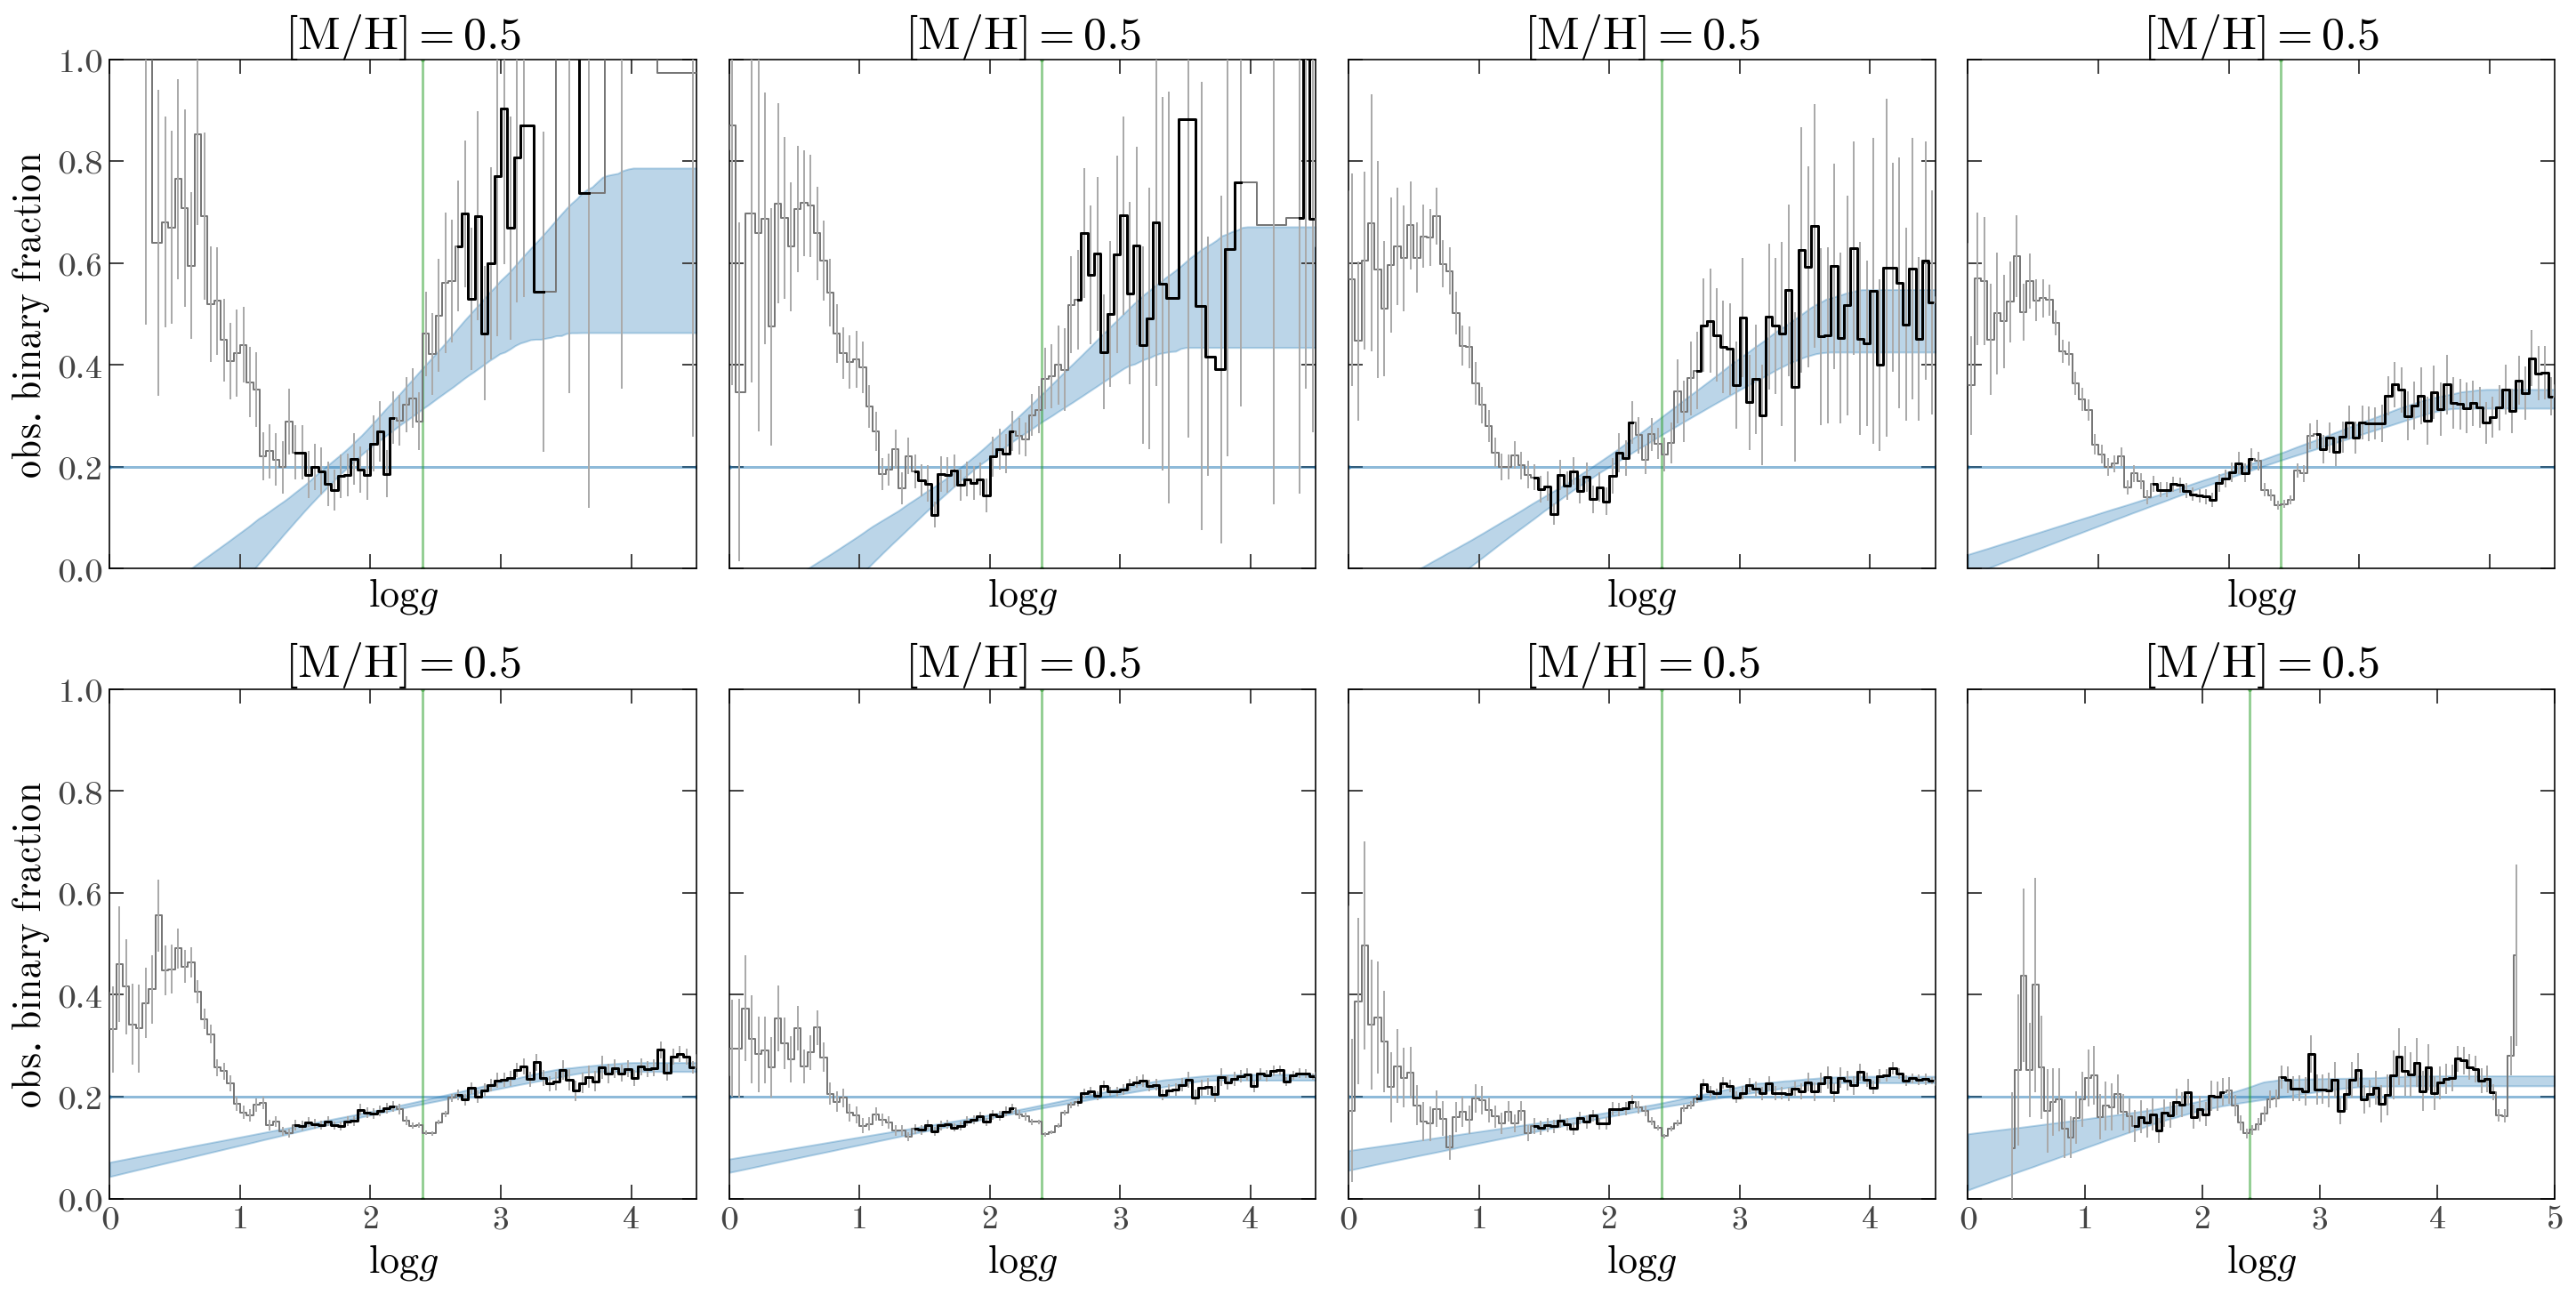

In [52]:
fig, axes = plt.subplots(2, 4, 
                         figsize=(4 * 5, 2 * 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i, r in enumerate(rows):
    ax = axes.flat[i]
    
#     ax.plot(r['fit_x'],
#             r['fit_y'],
#             marker='', drawstyle='steps-mid', color='k', zorder=100)
    
    _idx = np.concatenate(([0], np.where(np.diff(r['fit_x']) > 0.15)[0]+1, [len(r['fit_x'])]))
    for i1, i2 in zip(_idx[:-1], _idx[1:]):
        ax.plot(r['fit_x'][i1:i2],
                r['fit_y'][i1:i2],
                marker='', drawstyle='steps-mid', color='k', zorder=100)
    
    ax.plot(r['data_x'],
            r['data_y'],
            marker='', drawstyle='steps-mid', zorder=10,
            color='#777777', linewidth=1)
    
    ax.errorbar(r['data_x'],
                r['data_y'],
                r['data_yerr'],
                ecolor='#aaaaaa', ls='none', marker='', zorder=100, elinewidth=1)
    
    grid_x = np.linspace(0, 5, 128)
    pcl1, pcl2 = np.percentile(get_model_y(grid_x, r['mh_samples'], subN=512),
                               q=[5, 95], axis=0)
    ax.fill_between(grid_x, pcl1, pcl2, color='tab:blue', alpha=0.3)
    
    ax.set_title(r'$[{\rm M}/{\rm H}] = ' + f'{mh:.1f}$')
    ax.set_xlim(0., 4.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r'$\log g$')
    
    ax.axhline(0.2, color='tab:blue', alpha=0.5)
    ax.axvline(2.4, color='tab:green', alpha=0.5)

ax.set_xticks(np.arange(0, 5+1, 1))

for ax in axes[:, 0]:
    ax.set_ylabel('obs. binary fraction')

In [53]:
for i, r in enumerate(rows):
    print(f"M/H = {r['mh']:.2f}")
    print(f"Data at red clump: {r['data_y_min']:.3f} +/- {r['data_y_min_err']:.3f}")
    print(f"Model prediction: {r['pred_y_min']:.3f} +/- {r['pred_y_min_err']:.3f}")
    print(f"Difference: {r['pred_y_min'] - r['data_y_min']:.3f} +/- {np.sqrt(r['pred_y_min_err']**2 + r['data_y_min_err']**2):.3f}")
    print()

M/H = -1.80
Data at red clump: 0.461 +/- 0.083
Model prediction: 0.359 +/- 0.024
Difference: -0.101 +/- 0.087

M/H = -1.47
Data at red clump: 0.373 +/- 0.060
Model prediction: 0.322 +/- 0.017
Difference: -0.052 +/- 0.063

M/H = -1.14
Data at red clump: 0.224 +/- 0.033
Model prediction: 0.284 +/- 0.011
Difference: 0.060 +/- 0.035

M/H = -0.81
Data at red clump: 0.127 +/- 0.008
Model prediction: 0.222 +/- 0.004
Difference: 0.095 +/- 0.009

M/H = -0.49
Data at red clump: 0.129 +/- 0.004
Model prediction: 0.191 +/- 0.002
Difference: 0.062 +/- 0.005

M/H = -0.16
Data at red clump: 0.126 +/- 0.004
Model prediction: 0.182 +/- 0.002
Difference: 0.056 +/- 0.004

M/H = 0.17
Data at red clump: 0.123 +/- 0.004
Model prediction: 0.184 +/- 0.003
Difference: 0.062 +/- 0.005

M/H = 0.50
Data at red clump: 0.135 +/- 0.009
Model prediction: 0.208 +/- 0.010
Difference: 0.073 +/- 0.013



## Raw number counts

In [54]:
def get_number_data(mask, logg_bins=None):
    if logg_bins is None:
        logg_bins = np.arange(-0.25, 5.5, 0.05)
    
    logg_binc = 0.5 * (logg_bins[:-1] + logg_bins[1:])
    
    H_bin, _ = np.histogram(metadata['LOGG'][binaries_mask & mask], 
                            bins=logg_bins)
    H_all, _ = np.histogram(metadata['LOGG'][mask], 
                            bins=logg_bins)
    
    return logg_binc, H_bin, H_all

In [ ]:
fig, axes = plt.subplots(2, 4, 
                         figsize=(4 * 5, 2 * 5),
                         sharex=True, 
                         constrained_layout=True)

for i, r in enumerate(rows):
    ax = axes.flat[i]
    
    binc, H_bin, H_all = get_number_data(r['mh_mask'])
    
    ax.plot(binc, H_all,
            marker='', drawstyle='steps-mid', zorder=10,
            color='#777777', linewidth=1)
    
    ax.plot(binc, H_bin,
            marker='', drawstyle='steps-mid', zorder=10,
            color='k', linewidth=1)
    
    ax.set_title(r'$[{\rm M}/{\rm H}] = ' + f'{mh:.1f}$')
    ax.set_xticks(np.arange(0, 5+1, 1))
    ax.set_xlim(0., 4.5)
    # ax.set_ylim(0, 0.6)
    ax.set_xlabel(r'$\log g$')
    
    ax.axhline(0.2, color='tab:blue', alpha=0.5)
    ax.axvline(2.4, color='tab:green', alpha=0.5)

for ax in axes[:, 0]:
    ax.set_ylabel('number')